Building a regression model
1. Split the data into training and test sets, in order to ensure that we assess the
performance of our method on observations not seen during training.
2. Use cross-validation to evaluate different choices of model parameters (e.g., K in a KNN model).


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# By default, sklearn transformers (eg. standardscaler, onehotencoder, columntransformer) returns numpy arrays when I call .fit_transform() or .transform(),
# this means I lose column names and everything becomes a plain numeric array
# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [113]:
# Reading cleaned ttc data in excel file format
ttc = pd.read_excel(r'C:\Users\irene\DSI\team_project\ttc-streetcar-delay-data-2024_cleaned.xlsx')

# 1. Conver time to a numeric feature
# Turning 'Time' & 'Date' into datetime series
# The reason why I needed to add ...(..., format='%H:%M') is because Pandas doesn't know that I mean "the time of day", so it'll output full timestamps, assigning today's date (current system date) by defualt
ttc['Date'] = pd.to_datetime(ttc['Date'])
ttc['Time'] = pd.to_datetime(ttc['Time'], format='%H:%M').dt.time 

ttc['Minutes_since_midnight'] = ttc['Time'].apply(lambda x: x.hour * 60 + x.minute)

In [114]:
# The cyclical problem: Python will look at 23:59 and 00:01 as ~24 hrs apart, even though it's only 2 mins apart
# Example: time in hours, date as day of year

ttc['sin_time'] = np.sin(2 * np.pi * ttc['Minutes_since_midnight'] / 1440)
ttc['cos_time'] = np.cos(2 * np.pi * ttc['Minutes_since_midnight'] / 1440)


In [115]:
ttc.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season,Minutes_since_midnight,sin_time,cos_time
0,2024-04-28,301,03:54:00,Sunday,WOLSELEY LOOP,Cleaning - Unsanitary,30,60,E,8118,4,18,28,3,Spring,234,0.852640,0.522499
1,2024-09-14,301,02:23:00,Saturday,WOLSELEY LOOP,Utilized Off Route,30,60,W,8112,9,37,14,2,Summer,143,0.584250,0.811574
2,2024-01-28,301,02:11:00,Sunday,WARDEN AND COMSTOCK,Mechanical,10,20,W,8734,1,5,28,2,Winter,131,0.540974,0.841039
3,2024-11-15,301,02:35:00,Friday,THE QUEENSWAY AND WIND,Security,24,39,W,4588,11,46,15,2,Fall,155,0.625923,0.779884
4,2024-08-25,301,03:11:00,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10,30,E,4569,8,35,25,3,Summer,191,0.740218,0.672367


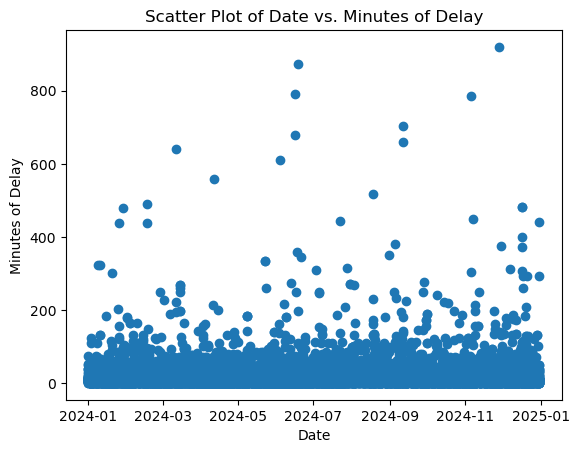

In [116]:
# Plot
plt.scatter(ttc['Date'], ttc['Min Delay'])

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Minutes of Delay")
plt.title("Scatter Plot of Date vs. Minutes of Delay")
plt.show()

In [117]:
# 2. Split into features (x-axis) and target (y-axis)

# Using cyclical code (sin_time, cos_time) as predictors
X = ttc[['sin_time', 'cos_time']]
y = ttc['Min Delay']

# Setting train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75, random_state=1)

In [118]:
ttc_train, ttc_test = train_test_split(
    ttc, train_size = 0.75, shuffle = True, random_state = 1
)

In [119]:
X_train = ttc_train[['sin_time', 'cos_time']]
y_train = ttc_train['Min Delay']

In [120]:
# 3. Initialize KNN Regressor
knn_regressor = KNeighborsRegressor()

# 4. Define parameter grid for GridSearchCV, or set of values of K we want to explore
param_grid = {
    "n_neighbors": range(1, 201, 3),
}

In [121]:
# 5. 5. Initialize and fit GridSearchCV
ttc_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

ttc_gridsearch.fit(X_train, y_train)

# 6. Retrieve and format results
results_complex = pd.DataFrame(ttc_gridsearch.cv_results_) # After fitting the model, we extract the cross-validation results using 'cv_results_'. This option incl various metrics & parameters tested using the cross-validation process
results_simplified = (
    results_complex[[ # Show only the results for "param_n_neighbors" & "mean_test_scores" columns
        "param_n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_n_neighbors": "n_neighbors"}) # rename the "param_n_neighbors" to just "n_neighbors"
)

print(results_simplified)

    n_neighbors  mean_test_score
0             1       -47.380564
1             4       -39.663592
2             7       -37.597528
3            10       -36.844363
4            13       -36.511541
..          ...              ...
62          187       -35.249098
63          190       -35.243484
64          193       -35.246825
65          196       -35.245198
66          199       -35.245207

[67 rows x 2 columns]


In [122]:
# Here I'm finding out what column names there are in the cross validation "results_complex" data frame
column_names = list(results_complex.columns.values)
column_names

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_n_neighbors',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [123]:
# Outputs an array, but we want it in a pd dataframe
ttc_gridsearch.cv_results_

{'mean_fit_time': array([0.00920234, 0.00880756, 0.00919657, 0.00870519, 0.00920215,
        0.0085041 , 0.00870285, 0.008705  , 0.00900025, 0.00839872,
        0.00859814, 0.00860324, 0.00860233, 0.00920463, 0.00879955,
        0.00870566, 0.00920229, 0.0086019 , 0.00850234, 0.00930524,
        0.00880189, 0.00899901, 0.00890412, 0.01010609, 0.00960183,
        0.00980124, 0.01059809, 0.01420441, 0.00920291, 0.00970287,
        0.00910487, 0.00907364, 0.00890317, 0.00911479, 0.00859604,
        0.00870781, 0.00839906, 0.0096045 , 0.00940022, 0.00880814,
        0.0090003 , 0.00960069, 0.00920143, 0.00940323, 0.00850339,
        0.0087986 , 0.00940223, 0.0085814 , 0.00890632, 0.00830588,
        0.00900135, 0.00900307, 0.00820165, 0.00860019, 0.00850592,
        0.00940204, 0.00899873, 0.00901084, 0.00821056, 0.00910401,
        0.00874205, 0.00880113, 0.00891166, 0.00860286, 0.00899878,
        0.00899982, 0.00860386]),
 'std_fit_time': array([9.78090869e-04, 4.03332101e-04, 4.0207698

In [124]:
# RMSPE is always non-negative because it measures how far off the model's predictions are from the actual values (distance can't be negative)
# However, sklear was built to always maximize scores and since RMSPE is a metric where lower is better, it flips it to a negative value
# This allows sklearn to treat like a score to maximize, even though we're trying to minimize the error
# In order to get the actual RMSPE values, we need to convert neg --> positive
  
# Could also code this as results["mean_test_score"] = results["mean_test_score"].abs()
results_simplified["mean_test_score"] = -results_simplified["mean_test_score"]
results_simplified

,n_neighbors,mean_test_score
0,1,47.380564
1,4,39.663592
2,7,37.597528
3,10,36.844363
4,13,36.511541
...,...,...
62,187,35.249098
63,190,35.243484
64,193,35.246825
65,196,35.245198


In [125]:
# By finding the smallest RMSPE, we can determine the best number of neighbors for our model. In this case, the lowest RMSPE is when we have 157 neighbors
results_simplified.nsmallest(1, 'mean_test_score')

,n_neighbors,mean_test_score
63,190,35.243484


In [126]:
# Double-checking
ttc_gridsearch.best_params_

{'n_neighbors': 190}

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

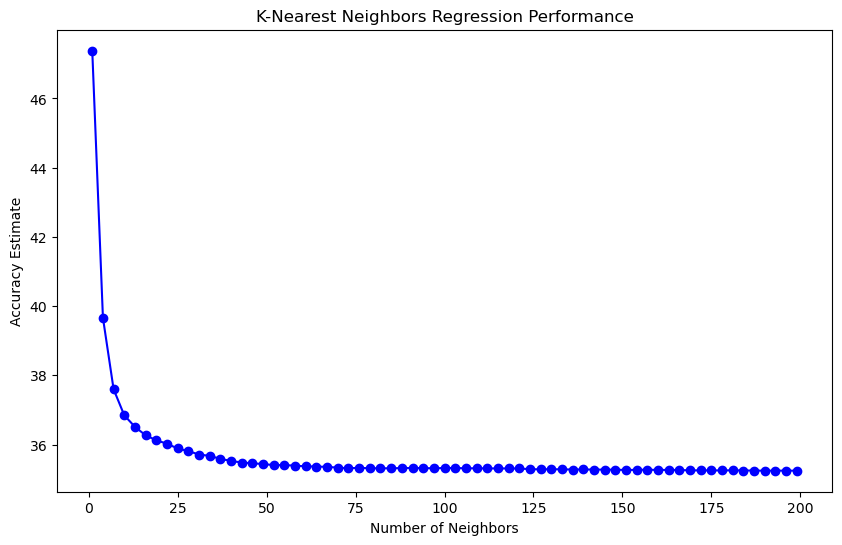

In [127]:
# Create the plot
plt.figure(figsize=(10,6))

# Plot mean test scores with error bars
plt.plot(results_simplified['n_neighbors'], results_simplified['mean_test_score'], '-o', color = 'blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Estimate')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout

In [128]:
ttc_test

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season,Minutes_since_midnight,sin_time,cos_time
12781,2024-12-14,511,11:40:00,Saturday,BATHURST,General Delay,25,35,N,4618,12,50,14,11,Fall,700,0.087156,-0.996195
2011,2024-05-16,501,14:45:00,Thursday,PARLIAMENT AND RICHMOND,Held By,10,20,N,4463,5,20,16,14,Spring,885,-0.659346,-0.751840
8532,2024-01-07,506,15:48:00,Sunday,HIGH PARK LOOP,Collision - TTC Involved,10,20,E,4556,1,2,7,15,Winter,948,-0.838671,-0.544639
6715,2024-07-24,505,08:54:00,Wednesday,DUNDAS WEST STATION,Collision - TTC Involved,83,93,W,4480,7,30,24,8,Summer,534,0.725374,-0.688355
218,2024-10-18,305,05:15:00,Friday,BROADVIEW AND KINTYRE,Emergency Services,15,30,S,4437,10,42,18,5,Fall,315,0.980785,0.195090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2024-11-13,503,09:46:00,Wednesday,RUSSELL YARD,Held By,10,20,NaN,4628,11,46,13,9,Fall,586,0.551937,-0.833886
13678,2024-11-11,512,14:22:00,Monday,ROBINA AND ST CLAIR,Security,3,6,N,9230,11,46,11,14,Fall,862,-0.580703,-0.814116
2619,2024-08-30,501,07:01:00,Friday,GERRARD AND ST MATHEWS,Emergency Services,5,10,W,8139,8,35,30,7,Summer,421,0.964787,-0.263031
2687,2024-09-20,501,16:09:00,Friday,GERRARD AND BROADVIEW,Emergency Services,0,0,W,8148,9,38,20,16,Summer,969,-0.884988,-0.465615


In [129]:
# Model Evaluation
# rmse is about a 30 minutes error for any new observations
ttc_test["predicted"] = ttc_gridsearch.predict(ttc_test[["sin_time", "cos_time"]])

rmse = mean_squared_error(
    y_true = ttc_test["Min Delay"],
    y_pred = ttc_test["predicted"]
)**0.5

rmse

30.545875206924396

In [130]:
# Calculate R2
r2 = r2_score(
    y_true=ttc_test["Min Delay"],
    y_pred=ttc_test["predicted"]
)
r2

-0.002719740089576206

{'n_neighbors': 190}


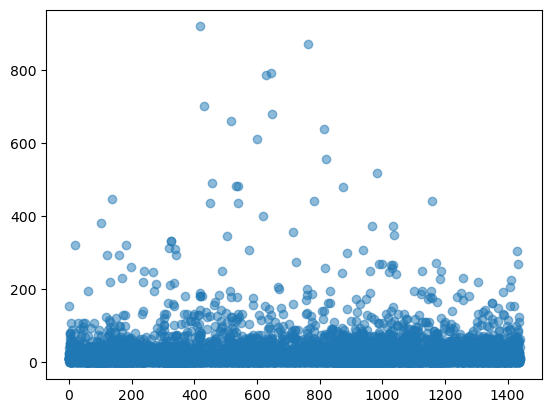

In [135]:
# 1️⃣ Inspect feature relationships
plt.scatter(ttc['Minutes_since_midnight'], ttc['Min Delay'], alpha=0.5)

# 2️⃣ Try different K values
print(ttc_gridsearch.best_params_)

# 3️⃣ Try adding more predictors
X_train = ttc_train[["sin_time", "cos_time", "Line", "Day", "Bound"]]


In [ ]:
# Linear Regression Model:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Using cyclical encoding as predictors
X = ttc[['sin_time', 'cos_time']]
y = ttc['Min Delay']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [ ]:
# 3. Evaluate performance
print("MAE:", mean_absolute_error(y_test,y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 13.334972831593463
R2: -0.001452834201852271


Text(0.5, 1.0, 'Actual vs. Predicted TTC Delays in Minutes')

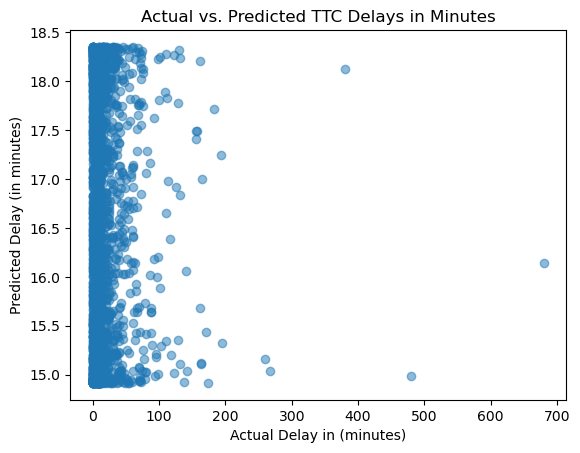

In [ ]:
# Visualize predictions
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("Actual Delay in (minutes)")
plt.ylabel("Predicted Delay (in minutes)")
plt.title("Actual vs. Predicted TTC Delays in Minutes")